<a href="https://colab.research.google.com/github/Madelavishnu/Madelavishnu/blob/main/Transformer_Encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import math
import torch.nn.functional as F

In [30]:
def scaled_dot_product(q, k, v, mask = None):
  # q, k, v = 30 * 8 * 200 * 64
  d_k = q.size()[-1]   # 64
  scaled = torch.matmul(q, k.transpose(-1,-2))/math.sqrt(d_k)   # 30 * 8 * 200 * 200
  if mask is not None:
    scaled+= mask
  attention = F.softmax(scaled, dim = -1)   # 30 * 8 * 200 * 200
  values = torch.matmul(attention, v)      # 30 * 8 * 200 * 64
  return values, attention

class Multiheadattention(nn.Module):
  def __init__(self, d_model, num_heads):
    super().__init__()
    self.d_model = d_model           #512
    self.num_heads = num_heads        # 8
    self.head_dim = d_model//num_heads # 64
    self.qkv_layer = nn.Linear(d_model, 3* d_model)   #  512 * 1536
    self.linear_layer = nn.Linear(d_model, d_model)   # 512 * 512


  def forward(self, x, mask = None):
    batch_size, seq_len, d_model = x.size()       # 30 * 200 * 512
    qkv = self.qkv_layer(x)                       # 30 * 200 * 1536
    qkv = qkv.reshape(batch_size, seq_len, self.num_heads, 3 * self.head_dim)  # 30 * 200 * 8 * 192
    qkv = qkv.permute(0,2,1,3)       # 30 * 8 * 200 * 192
    q, k, v = qkv.chunk(3, dim = -1)    # each 30 * 8 * 200 * 64

    values, attention = scaled_dot_product(q,k,v, mask)
    #  attenton = 30 * 8 * 200 * 200  , values = 30 * 8 * 200 * 64
    values = values.reshape(batch_size, seq_len, self.num_heads * self.head_dim) # 30* 200 * 512(here 512 is 8 times of 64)

    out = self.linear_layer(values)
    return out


In [31]:
class LayerNoramlization(nn.Module):
  def __init__(self, parameters_shape, eps = 1e-5):
    super().__init__()
    self.parameters_shape = parameters_shape  # 512
    self.eps = eps
    self.gamma = nn.Parameter(torch.ones(parameters_shape))   # 512
    self.beta = nn.Parameter(torch.zeros(parameters_shape))   # 512

  def forward(self, inputs): # 30 * 200 * 512

    dims = [-(i+1) for i in range(len(self.parameters_shape))]   #[-1]
    mean = torch.mean(inputs, dim = dims, keepdim = True)       # 30 * 200 * 1


    var = ((inputs - mean)**2).mean(dim = dims, keepdim = True)   # 30 * 200 * 1
    std = (var +self.eps).sqrt()                        # 30 * 200 * 1

    y = (inputs-mean)/std                                # 30 * 200 * 512
    out = self.gamma *y +self.beta                       # 30 * 200 * 512

    return out


In [40]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, hidden, drop_prob = 0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, hidden)      # 512 * 2048
        self.linear2 = nn.Linear(hidden, d_model)      # 2048 * 512
        self.relu = nn.ReLU()                          # activation function makes -ve values  to 0 shows reamining
        self.dropout = nn.Dropout(p=drop_prob)

    def forward(self, x):           # 30 * 200 * 512
        x = self.linear1(x)       # 30 * 200 * 2048
        x = self.relu(x)          # 30 * 200 * 2048
        x = self.dropout(x)       # 30 * 200 * 2048
        x = self.linear2(x)       #  30 * 200 * 512
        return x

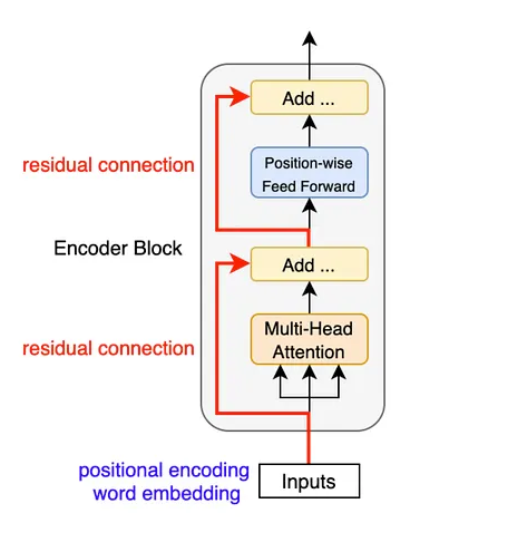

In [41]:

class EncoderLayer(nn.Module):
  def __init__(self, d_model, ffn_hidden, num_heads, drop_prob):
    super(EncoderLayer,self).__init__()

    self.attention = Multiheadattention(d_model = d_model, num_heads = num_heads)
    self.norm1 = LayerNoramlization(parameters_shape = [d_model])
    self.dropout1 = nn.Dropout(p = drop_prob)
    self.ffn = PositionwiseFeedForward(d_model = d_model, hidden = ffn_hidden, drop_prob = drop_prob)
    self.norm2 = LayerNoramlization(parameters_shape = [d_model])
    self.dropout2 = nn.Dropout(p = drop_prob)

  def forward(self, x):
    residual_x = x                      # 30* 200 * 512
    x = self.attention(x, mask = None)  # 30* 200 * 512
    x = self.dropout1(x)                # 30* 200 * 512
    x = self.norm1(x + residual_x)      # 30 * 200 * 512
    residual_x = x
    x = self.ffn(x)
    x = self.dropout2(x)
    x = self.norm2(x + residual_x)
    return x





class Encoder(nn.Module):
  def __init__(self, d_model, ffn_hidden, num_heads, drop_prob, num_layers):
    super().__init__()
    self.layers = nn.Sequential(*[EncoderLayer(d_model, ffn_hidden, num_heads, drop_prob)
    for _ in range(num_layers)])           #execute this for 5 times


  def forward(self,x):           # take input and propagate
    x = self.layers(x)           # it pass all 5 encoder layers
    return x

In [42]:
# model parameters

d_model = 512          # size of every single vector
num_heads = 8          # make q, k, v of 8 heads for each to pass in multi head attention
drop_prob = 0.1        # 10% of set neuron off
batch_size = 30        # pass some multiple examples at same time
seq_len = 200          # total no of words you are passing (reamaining goes into padding <PAD>)
ffn_hidden = 2048      # make feed forward network of neurons 2048
num_layers = 5         # no of transformers unit we have to encode (N x ) no of encoder layer

encoder = Encoder(d_model, ffn_hidden, num_heads, drop_prob,num_layers)

In [44]:
x = torch.randn((batch_size, seq_len, d_model))
out = encoder(x)
out

tensor([[[-0.1244, -0.3879, -0.9462,  ...,  0.7328, -0.4949, -1.7758],
         [ 0.0969,  1.1139, -0.7559,  ...,  1.3936,  0.2521,  0.0239],
         [ 1.0270,  0.7264, -0.2761,  ...,  0.0231,  0.4779,  0.3776],
         ...,
         [ 0.0138,  0.0485, -0.2196,  ...,  0.9444, -0.6742, -0.0943],
         [-0.2890, -0.3405, -2.0746,  ...,  0.6780,  1.4034, -0.2938],
         [ 1.1118,  0.1363,  0.0387,  ..., -0.2205,  0.6556, -0.5839]],

        [[ 0.2434, -0.3020, -1.1422,  ...,  0.1828, -2.1492, -0.5739],
         [ 2.6636, -0.7802,  0.5022,  ..., -1.6464, -0.3552,  1.8472],
         [-0.0236,  0.0833, -0.1748,  ...,  0.2030,  1.5228, -0.5452],
         ...,
         [-0.4172,  0.9408, -0.1777,  ..., -0.2263, -0.5887, -0.1254],
         [-0.4785,  0.1268,  1.1289,  ..., -0.2797,  0.5497,  0.2232],
         [-1.5334, -0.4725,  1.1168,  ..., -0.3799, -1.8397,  0.0951]],

        [[-0.1973, -1.9791, -0.1220,  ...,  0.1091, -0.7634,  0.9946],
         [ 0.5429, -0.3447,  0.4321,  ...,  1